In [1]:
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import glob 

from skimage.util.shape import view_as_windows
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.cluster import KMeans
from sklearn import datasets
from env.spawn.SpawnStragety import FlatGroundSpawnStrategy

In [2]:
%%html
<style>

div.output_scroll {
    height : auto;
}
</style>

In [3]:
%matplotlib notebook

In [4]:
def interact2strategy(hm_path):
    strat = FlatGroundSpawnStrategy(hm_path, debug=True, scale=10)
    strat(k=100, tol=1e-1, step=5, size=45)

interact(interact2strategy, hm_path=glob.glob('/home/francesco/Documents/Master-Thesis/core/maps/test/*.png'))

interactive(children=(Dropdown(description='hm_path', options=('/home/francesco/Documents/Master-Thesis/core/m…

<function __main__.interact2strategy(hm_path)>

In [32]:
flat = np.zeros((500,500))

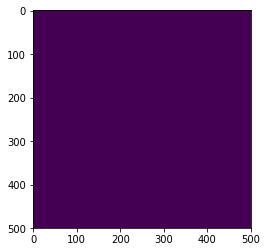

In [33]:
plt.imshow(flat)

In [34]:
center = flat.shape[0]//2, flat.shape[1]//2

center

(250, 250)

In [35]:
offset = 70 // 2

In [36]:
temp = flat.copy()

In [37]:
temp[256 - offset:256 + offset, 256 - offset:256 + offset] = 50

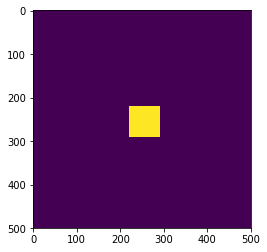

In [38]:
plt.imshow(temp)

In [39]:
cv2.imwrite('/home/francesco/Desktop/flat2.png', temp)

True